In [15]:
from MDbrew.opener import DumpOpener

file_path = '../../../data/dump.RUN.lammpstrj'
brew = DumpOpener(file_path=file_path)
database = brew.get_database()
columns = brew.get_columns()

In [16]:
import numpy as np
import pandas as pd
iter_N = len(database)
pos_columns = columns[2:]
oxygen_database = []
for idx in range(iter_N):
    df_database = pd.DataFrame(data=database[idx], columns=columns)
    df_oxygen = df_database[df_database['type']==1]
    pos_oxygen = df_oxygen[pos_columns]
    oxygen_database.append(np.array(pos_oxygen))
oxygen_database = np.array(oxygen_database)

In [17]:
import time
def timeCount(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} : {end - start :5.2f} s")
        return result
    return wrapper

# MSD Simple

In [18]:
@timeCount
def get_msd_direct_for(position: np.ndarray) -> list[float]:
    """ MSD

    Calculate the MSD list with linear loop
    
    Time complexity : O(N**2)
    
    Args:
        position (np.ndarray): Data of Particle's position in each lag time 
            - shape = [Number of lag, Number of particle, Coordinate data]

    Returns:
        list[float]: MSD data of each lag time
    """
    lag, N, dim = position.shape
    initial_position = oxygen_database[0]
    msd = [0]
    # 각 lag에서 모습을 보여주는 것입니다.
    for t in range(1, lag):
        current_position = position[t]
        unit_msd = 0
        # N particel의 거리차의 제곱의 평균을 구하는 과정
        for n in range(N):
            diff_position = current_position[n] - initial_position[n]
            # 벡터의 크기를 구하는 과정
            for d in range(dim):
                unit_msd += diff_position[d] * diff_position[d]
        msd.append(unit_msd / n)            
    return msd

In [19]:
@timeCount
def get_msd_direct_np(position: np.ndarray) -> list[float]:
    """ MSD - Pythonic Code

    Calculate the MSD list with linear loop with numpy function
    
    Time complexity : O(N**2)
    
    Args:
        position (np.ndarray): Data of Particle's position in each lag time 
            - shape = [Number of lag, Number of particle, Coordinate data]

    Returns:
        list[float]: MSD data of each lag time
    """
    def cal_msd(diff_pos):
        return np.square(diff_pos).sum(axis=1).mean()

    initial_position = oxygen_database[0]
    msd = [cal_msd(np.subtract(current_position, initial_position)) for current_position in position]
    return msd


In [20]:
@timeCount
def get_msd_direct_linalg(position: np.ndarray) -> list[float]:
    """ MSD with numpy linalg

    Args:
        position (np.ndarray): Data of Particle's position in each lag time 
            - shape = [Number of lag, Number of particle, Coordinate data]
    Returns:
        list[float]: MSD data of each lag time
    """
    norm = np.linalg.norm(np.subtract(position, position[0]), axis=-1)
    msd  = norm * norm
    msd_list = msd.mean(axis=1)
    return msd_list

get_msd_direct_for :  3.81 s
get_msd_direct_np :  0.06 s
get_msd_direct_linalg :  0.10 s


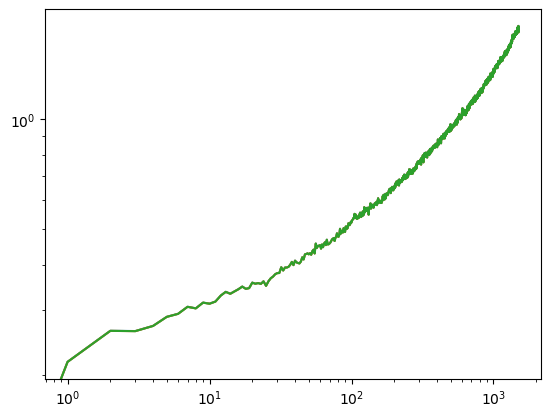

In [21]:
import matplotlib.pyplot as plt
msd_direct_for = get_msd_direct_for(oxygen_database)
msd_direct_np = get_msd_direct_np(oxygen_database)
msd_direct_linalg = get_msd_direct_linalg(oxygen_database)
plt.loglog(msd_direct_for, label='for')
plt.loglog(msd_direct_np, label='np')
plt.loglog(msd_direct_linalg, label='linalg')

# Linear Regression

0.0008220772108072
0.5252279480650994


/tmp/ipykernel_1826/2507672769.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_ = np.linalg.lstsq(in_X.T, in_y)[0]


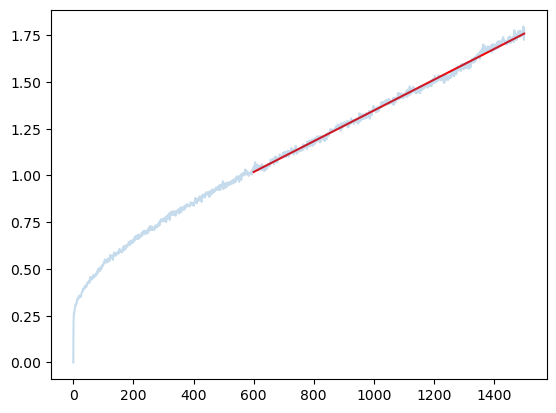

In [22]:
X = list(range(1501))
y = msd_direct_np
in_X = np.array([X[600:], np.ones(901)])
in_y = np.array(msd_direct_np[600:])
w_ = np.linalg.lstsq(in_X.T, in_y)[0]
x = in_X[0]
f = lambda x : w_[0] * x + w_[1]
plt.plot(x, f(x), 'r')
plt.plot(X,y, alpha = 0.25)
print(w_[0])
print(w_[1])

In [23]:
import numpy as np
import matplotlib.pyplot as plt


class LinearRegression():
    def __init__(self, eta=0.01, n_iter=10000, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    @timeCount
    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=(2,1))
        # self.w_ = np.array([[0.2],[0]])
        self.n = len(X)
        self.costs_ = []
        self.steps_ = []
        
        for step in range(self.n_iter):
            self.costs_.append(self.cost())
            self.update_w_()
            self.steps_.append(step)
            
            # if self.costs_[-1] <= 1e-6:
            #     print(1)
            #     break
            
        self.plot_cost_and_data()
            
    def cost(self):
        cost = np.dot(1/(2 * self.n), np.sum(np.square(np.subtract(self.hypothesis(), self.y))))
        return cost
    
    def update_w_(self):
        w_gradient = self.eta / self.n * np.dot(np.subtract(self.hypothesis(), self.y).T, self.X)
        b_gradient = self.eta / self.n * np.sum(np.subtract(self.hypothesis(), self.y))
        self.w_[0] = np.subtract(self.w_[0], w_gradient)
        self.w_[1] = np.subtract(self.w_[1], b_gradient)
        
    def hypothesis(self):
        return np.add(np.dot(self.X, self.w_[0:1]), self.w_[1])
    
    def plot_cost_and_data(self):
        fig, axs = plt.subplots(1,2, constrained_layout=True)
        fig.tight_layout()
        # Cost Function
        axs[0].loglog(self.steps_, self.costs_, 'ko-')
        axs[0].set_xlabel('step (log)')
        axs[0].set_ylabel('cost (log) ')
        # Main Function
        axs[1].plot(self.X, self.hypothesis(), color='black')
        axs[1].scatter(self.X, self.y, color='red', alpha=0.10)
        axs[1].set_xlabel('X' )
        axs[1].set_ylabel('Y')

fit :  0.40 s


/tmp/ipykernel_1826/855660198.py:49: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


array([[0.00082208],
       [0.52522795]])

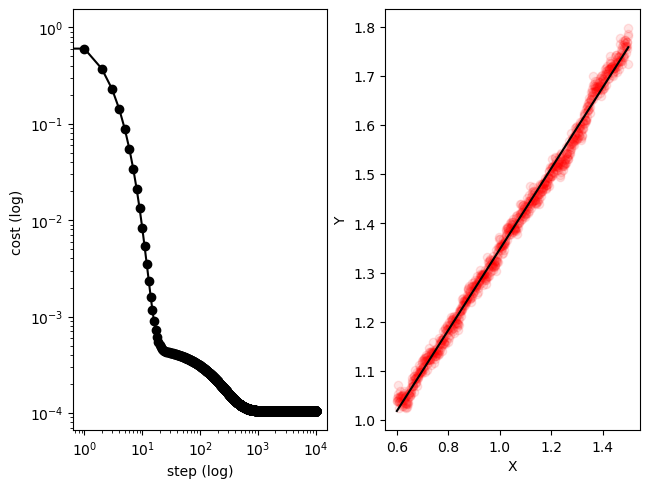

In [24]:
lR = LinearRegression(eta=0.1, n_iter=10000, random_state=1)
X = in_X[0].reshape(-1,1) / 1000
y = in_y.reshape(-1,1) 
lR.fit(X, y)
lR.w_[0] /= 1000
lR.w_

# MSD with Window 
$MSD(m) = \frac 1 {N_{particles}} \sum_{i=1}^{N_{particles}} \frac 1 {N-m} \sum_{k=0}^{N-m-1} (r_i(k+m)-r_i(k))^2$  
   
$MSD List = \sum_{m=0}^{N-1} \frac 1 {N_{particles}} \sum_{i=1}^{N_{particles}} \frac 1 {N-m} \sum_{k=0}^{N-m-1} (r_i(k+m)-r_i(k))^2$  


In [25]:
import tqdm
@timeCount
def get_msd_window_for(r_: np.ndarray):
    N, N_particle, dim = r_.shape
    msd_list = [0]
    for m in tqdm.trange(1, N):
        unit_msd = 0
        for i in range(N_particle):
            unit_particle = 0
            for k in range(N - m):
                norm_r_ = 0
                for d in range(dim):
                    diff_r_ = r_[k+m, i, d] - r_[k, i, d]
                    norm_r_ += diff_r_ * diff_r_
                unit_particle += norm_r_
            unit_particle /= (N - m)
            unit_msd += unit_particle
        unit_msd /= N_particle
        msd_list.append(unit_msd)
    return msd_list

In [26]:
@timeCount
def get_msd_window_np(position: np.ndarray):
    N, N_particle, dim = position.shape
    msd_list = np.zeros((N, N_particle))
    for lag in np.arange(1, N):
        diff = position[lag:] - position[:-lag]
        sqdist = np.square(diff).sum(axis=-1)
        msd_list[lag, :] = np.mean(sqdist, axis=0)
    timeseries = msd_list.mean(axis=1)
    return timeseries

In [27]:
msd_window_for = get_msd_window_for(oxygen_database[::10])
msd_window_np = get_msd_window_np(oxygen_database[::10])

100%|██████████| 150/150 [00:25<00:00,  5.84it/s]


get_msd_window_for : 25.71 s
get_msd_window_np :  0.53 s


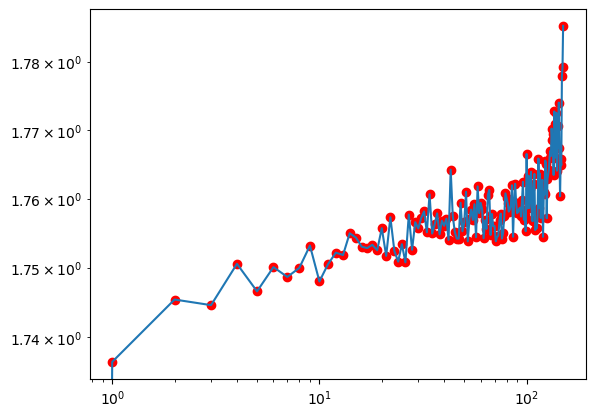

In [28]:
plt.loglog(msd_window_for, 'ro')
plt.loglog(msd_window_np)

# MSD with FFT

$MSD List =  \frac 1 {N_{particles}} \sum_{i=1}^{N_{particles}} \sum_{m=0}^{N-1}  \frac 1 {N-m} \sum_{k=0}^{N-m-1} (r_i(k+m)-r_i(k))^2$  

$D(k) = r^2(k)~~(k = 0,1, \cdots , N-1) $  
$Q = 2 \sum_{k=0}^{N-1} D(k)$  
  
$From~m = 0 , \cdots , N-1$  
$~~~ Q -= D(m-1) - D(N-m)$  
$~~~ S_1(m) = Q / (N - m)$  
  
$S_2(m) = \frac 1 {N-m} \sum_{k=0}^{N-m-1} r(k)\cdot r(k+m)$  
  
$MSD(m) = S_1(m) - 2S_2(m)$

zero-padding 이유 : https://dsp.stackexchange.com/questions/741/why-should-i-zero-pad-a-signal-before-taking-the-fourier-transform

In [29]:
# input
def auto_correlation(r):
    axis_dict = {'lag': 0, 'N_particle': 1, 'pos': -1}
    r = np.asarray(r, dtype=float)
    N = len(r)
    X = np.fft.fft(r, n=2*N, axis=axis_dict['lag'])
    psd = X * X.conjugate()
    x = np.fft.ifft(psd, axis=axis_dict['lag'])
    x = x[:N].real
    x = x.sum(axis=axis_dict['pos'])
    n = np.arange(N,0,-1)
    return x / n [:, np.newaxis]

@timeCount
def get_msd_fft(r):
    axis_dict = {'lag': 0, 'N_particle': 1, 'pos': -1}
    r = np.asarray(r, dtype=float)

    N, N_particle = r.shape[:2]
        
    D = np.square(r).sum(axis=axis_dict['pos'])
    D = np.append(D, np.zeros((N, N_particle)), axis=axis_dict['lag'])
    Q = 2 * np.sum(D, axis=axis_dict['lag'])
    S_1 = np.zeros((N, N_particle))
    for m in range(N):
        Q -= (D[m-1, :] + D[N-m, :])
        S_1[m, :] = Q / (N-m)
    
    S_2 = auto_correlation(r)
    return np.subtract(S_1, 2*S_2).mean(axis=axis_dict['N_particle'])

In [30]:
msd_window_fft = get_msd_fft(oxygen_database)
msd_window_np_full = get_msd_window_np(oxygen_database)

get_msd_fft :  1.37 s
get_msd_window_np : 47.77 s


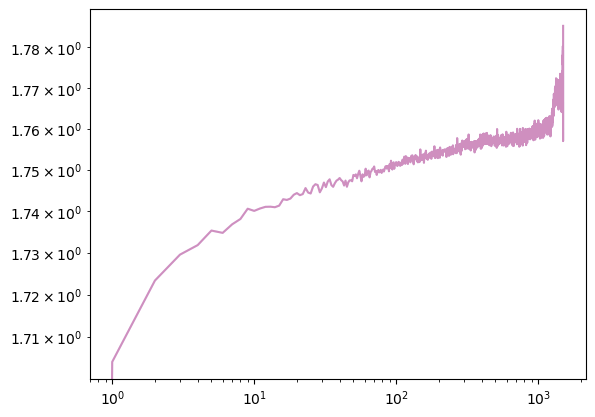

In [31]:
plt.loglog(msd_window_fft, 'b-', alpha=0.25)
plt.loglog(msd_window_np_full, 'r-', alpha=0.25)

$ X_k = \sum_{n=0}^{N-1} x_n\cdot e^{-i 2\pi kn /N}$  
  
$ x_n = \frac 1 N \sum_{k=0}^{N-1} X_k \cdot e ^{i*2 \pi k n / N}$

In [32]:
def FFT(x):
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N == 1:
        return x
    elif N % 2 > 0:
        raise ValueError(f"Size of x must be a power of 2 : Not {N}")
    else:
        X_even = FFT(x[::2])
        X_odd  = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:int(N / 2)].reshape(-1,1) * X_odd,
                               X_even + factor[int(N / 2):].reshape(-1,1) * X_odd])

In [33]:
def iFFT(X):
    X = np.asarray(X)
    N = len(x)
    if N == 1:
        return X
    else:
        x_even = FFT(x[::2])
        x_odd  = FFT(x[1::2])
        factor = np.exp(2j * np.pi * np.arange(N) / N)
        return np.concatenate([x_even + factor[:int(N / 2)].reshape(-1,1) * x_odd,
                               x_even + factor[int(N / 2):].reshape(-1,1) * x_odd]) / N